# Autoencoder for Super Resolution on Fashion MNIST

This AutoEncoder (AE) will try to remove the random noise on the pictures of clothings.<br>
The input data is the famous Fahsion MNIST with thousands of 28x28 pictures. <br>
Gaussian noise was added on the input data. <br>
The target images are the original images from the dataset.<br>
The input to the AE are the pictures that with additional noise.

## Import Modules

In [74]:
# visualization of images and analytic cruves
import matplotlib.pyplot as plt
# analytics
import numpy as np
# dl framework
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision
# accelerated dl framework
import pytorch_lightning as pl
from pytorch_lightning.trainer import Trainer

## Download Data and Transform

Define datasets and apply the typical transform to normalize the images to tensor of ranges from 0 to 1.

In [75]:
# download full dataset for trainin and validation
mnist_dataset = torchvision.datasets.FashionMNIST(root="",
                                                  transform=torchvision.transforms.Compose([
                                                  torchvision.transforms.ToTensor()]),
                                                  train=True,
                                                  download=True)

# split the entire dataset into validation and training set
mnist_train_dataset, mnist_val_dataset = random_split(dataset=mnist_dataset, 
                                                      lengths=[int(len(mnist_dataset)*0.9), 
                                                               int(len(mnist_dataset)*0.1)])

# download the test data
mnist_test_dataset = torchvision.datasets.FashionMNIST(root="",
                                                  transform=torchvision.transforms.Compose([
                                                  torchvision.transforms.ToTensor()]),
                                                  train=False,
                                                  download=True)

For the pytorch_lightning Trainer the dataset has to be put into a DataLoader that handles data supply for the algorithm on the fly.

In [76]:
batch_size = 32
shuffle = True
# train dataloader
mnist_train_dataloader = DataLoader(mnist_train_dataset,
                              batch_size=batch_size,
                              shuffle=shuffle)

# val dataloader
mnist_val_dataloader = DataLoader(mnist_val_dataset,
                              batch_size=batch_size,
                              shuffle=shuffle)

# test dataloader
mnist_test_dataloader = DataLoader(mnist_test_dataset,
                              batch_size=batch_size,
                              shuffle=shuffle)

Visualization of a random pictures from the training dataset displaying an ankle boot.

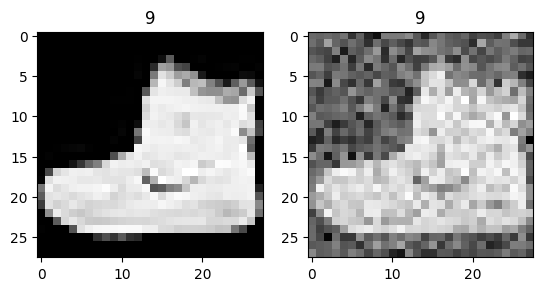

In [77]:
# plot image dependent on the index in the dataset
def visualize_picture(index: int) -> None:
    fig, (ax1, ax2) = plt.subplots(ncols=2, 
                                   nrows=1)
    # get image from dataset
    img = np.array(mnist_dataset[index][0]).reshape(28, 28)

    # generate noisy image
    img_noise = img + np.random.randn(28, 28) * 0.2
    
    # normalize image back to 0 to 1
    img_noise = (img_noise - img_noise.min())/(img_noise.max() - img_noise.min())

    # get the label of the image
    label = mnist_dataset[index][1]

    # plot images
    ax1.imshow(img, 
               cmap="Greys_r")
    ax1.set_title(label)
    ax2.imshow(img_noise, 
               cmap="Greys_r")
    ax2.set_title(label)

# example of mnist image
visualize_picture(0)

## Define AutoEncoder

Typical Autoencoder structure with 2x28 input and 3 linear layers that compress the data to a latent space of 10 dimensions.<br>
Afterwards the same architecture is applied to decode the latent space to a picture. <br>
The sigmoid at the end of the decoder enforces the output to be between 0 and 1 which is the range of the normalized picture.<br>
The gaussian noise is added during training on the input to the neural net. <br>
The MSE loss is used to calculate the distance (loss) between the decoded images and the regular images.<br>

In [80]:
# autoencoder in class structure
class SRAE(pl.LightningModule):
    def __init__(self,
                 hyperparamters):
        super().__init__()
        # hyperparamters dict
        self.hyperparameters = hyperparamters

        # losses
        self.epoch_end_train_loss = []
        self.epoch_end_val_loss = []
        self.training_loss = []
        self.validation_loss = []



        # loss criterion
        self.criterion = nn.MSELoss()

        # encoding procedure
        self.encode = nn.Sequential(
             nn.Linear(784, 200),
             nn.PReLU(),
             nn.Linear(200, 100),
             nn.PReLU(),
             nn.Linear(100, 10),
             nn.PReLU())


        # decoding procedure
        self.decode = nn.Sequential(
             nn.Linear(10, 100),
             nn.PReLU(),
             nn.Linear(100, 200),
             nn.PReLU(),
             nn.Linear(200,784),
             nn.Sigmoid()
             )


    def forward(self,x):

        # encode input to latent space
        encoded = self.encode(x)
        
        # decode from latent space
        decoded = self.decode(encoded)
        return decoded

    def training_step(self, batch, batch_idx):
        # extract the image from the bact
        x, _ = batch
        x = x.view(x.size(0), -1)

        # adding gaussiona noise to the image
        # to vary the noise amplitude, a random
        # factor is applied to scale the noise
        noise = torch.randn_like(input=x) * torch.rand(1)
        x_noise = x + noise

        # normalize to [0, 1]
        x_noise = (x_noise - x_noise.min())/(x_noise.max()-x_noise.min())

        # predicted image from AE 
        x_hat = self(x_noise)

        # using mean squared error to calculate 
        # the distance to the true values
        loss = self.criterion(x_hat, x)

        # save loss in list
        self.training_loss.append(loss.detach().numpy())

        # log the loss for better visualization
        self.log('train_loss', 
                 loss)
        return loss

    def validation_step(self, batch, batch_idx):
        # extract the image from the bact
        x, _ = batch
        x = x.view(x.size(0), -1)

        ## adding gaussiona noise to the image
        # to vary the noise amplitude, a random
        # factor is applied to scale the noise
        noise = torch.randn_like(input=x) * torch.rand(1)
        x_noise = x + noise

        # normalize to [0, 1]
        x_noise = (x_noise - x_noise.min())/(x_noise.max()-x_noise.min())

        # predicted image from AE 
        x_hat = self(x_noise)

        # using mean squared error to calculate 
        # the distance to the true values
        loss = self.criterion(x_hat, x)

        # save loss in list
        self.validation_loss.append(loss.detach().numpy())

        # log the loss for better visualization
        self.log('val_loss', 
                 loss)
        return loss

    def test_step(self, batch, batch_idx):
        # extract the image from the bact
        x, _ = batch
        x = x.view(x.size(0), -1)

        # adding gaussiona noise to the image
        # to vary the noise amplitude, a random
        # factor is applied to scale the noise
        noise = torch.randn_like(input=x) * torch.rand(1)
        x_noise = x + noise

        # normalize to [0, 1]
        x_noise = (x_noise - x_noise.min())/(x_noise.max()-x_noise.min())

        # predicted image from AE 
        x_hat = self(x_noise)

        # using mean squared error to calculate 
        # the distance to the true values
        loss = self.criterion(x_hat, x)

        # log the loss for better visualization
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        # adam optimizer
        optim = Adam(params= self.parameters(),
                     lr=self.hyperparameters["learning_rate"])
        return optim
    
    def on_epoch_end(self) -> None:
        self.epoch_end_val_loss.append(self.validation_loss[-1])
        #self.epoch_end_train_loss.append(self.training_loss[-1])
        return 

## Train AutoEncoder

In [81]:
# put hyperparams in dict
hyperparamters = {
    "batch_size": batch_size,
    "learning_rate": 1e-3,
    "max_epochs": 5
}
# initialize model
model = SRAE(hyperparamters=hyperparamters)

# initialize Trainer
trainer = Trainer(max_epochs=hyperparamters["max_epochs"])

# train the model
trainer.fit(model=model,
            train_dataloaders=mnist_train_dataloader,
            val_dataloaders=mnist_val_dataloader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | encode    | Sequential | 178 K 
2 | decode    | Sequential | 178 K 
-----------------------------------------
356 K     Trainable params
0         Non-trainable params
356 K     Total params
1.428     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/leonrenn/opt/miniconda3/envs/TorchExample/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


## Visualize Training

/var/folders/0m/2px4t5jj7zb9t33jz6srvdb00000gn/T/ipykernel_95576/766233265.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


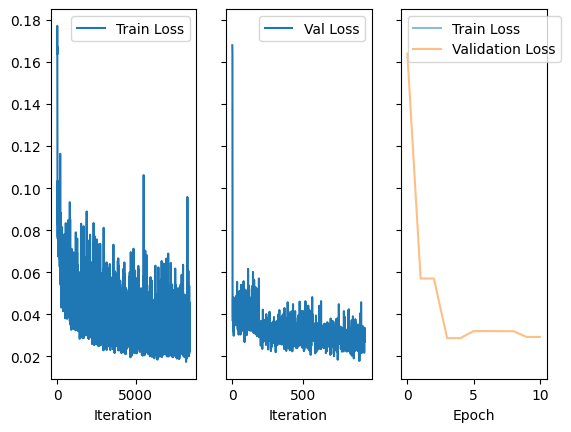

In [83]:
# visualize the models loss during trainin
def visualize_model(model):
    train_loss = model.training_loss
    val_loss = model.validation_loss
    train_loss_epoch_end = model.epoch_end_train_loss
    val_loss_epoch_end = model.epoch_end_val_loss

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,
                                   ncols=3,
                                   sharey=True)
    # train loss
    ax1.plot(train_loss, label="Train Loss")
    ax1.set_xlabel("Iteration")
    ax1.legend()

    # val loss
    ax2.plot(val_loss, label="Val Loss")
    ax2.set_xlabel("Iteration")
    ax2.legend()

    # train and val loss
    ax3.plot(train_loss_epoch_end, 
             label="Train Loss",
             alpha=0.5)
    ax3.plot(val_loss_epoch_end,
             label="Validation Loss",
             alpha=0.5)
    ax3.set_xlabel("Epoch")
    ax3.legend()
    

    fig.show()
    return

visualize_model(model=model)

## Visualization of Denoising

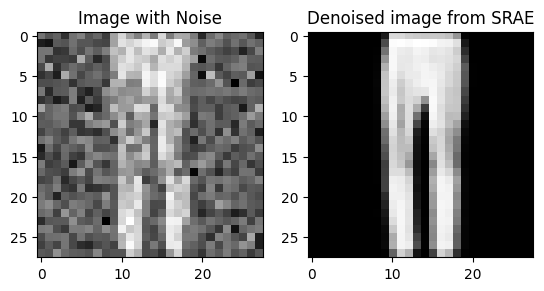

In [93]:
# plot image dependent on the index in the dataset
def visualize_picture(index: int) -> None:
    fig, (ax1, ax2) = plt.subplots(ncols=2, 
                                   nrows=1)
    # get image from dataset
    img = np.array(mnist_test_dataset[index][0], dtype=float).reshape(28, 28)

    # generate noisy image
    img_noise = img + np.random.randn(28, 28) * 0.2
    
    # normalize image back to 0 to 1
    img_noise = (img_noise - img_noise.min())/(img_noise.max() - img_noise.min())

    # flatten to input size
    img_denoised = img_noise.flatten()

    img_denoised = torch.tensor(img_denoised,dtype=torch.float)

    img_denoised = model(img_denoised).detach().numpy().reshape(28, 28)

    # plot images
    ax1.imshow(img_noise, 
               cmap="Greys_r")
    ax1.set_title("Image with Noise")
    ax2.imshow(img_denoised, 
               cmap="Greys_r")
    ax2.set_title("Denoised image from SRAE")

# example of mnist image
visualize_picture(3)

## Performance on Test

In [ ]:
# evaluate the performace on the test set
trainer.test(model=model,
             dataloaders=mnist_test_dataloader)

/Users/leonrenn/opt/miniconda3/envs/TorchExample/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:466: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/leonrenn/opt/miniconda3/envs/TorchExample/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.03103574551641941
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.03103574551641941}]

## Save the model

In [ ]:
torch.save(model.state_dict(), 
           f="SRAE.pt")

## Summary

Even though the model was only of very simple architecture, it performed pretty well removing noise from clothing images.<br>
To improve the model, one could mkae the layers to convolutional layers, train the model longer and ajust other hyperparameters.<br>
Have fun :)